<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>Деревья решений, случайные леса (практика)</center></h2>

**Срок сдачи:** 3 апреля 2017, 06:00 <br> 
**Штраф за опоздание:** -2 балла после 06:00 3 апреля, -4 балла после 06:00 10 апреля, -6 баллов после 06:00 17 апреля

При отправлении ДЗ указывайте фамилию в названии файла<br>

Не забудте создать задание в Slack через /todo.

Используйте данный Ipython Notebook при оформлении домашнего задания.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

In [2]:
wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",sep=';')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Практика

### Качество вина (10 баллов)

Давайте все-таки разберемся с [вином](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv)!


#### Задание (1 балл)
* Загрузите данные, выполните преобразование целевой переменной: 
    * quality > 5 -> 1
    * quality <= 5 -> 0
* Разделите выборку на обучающую и контрольную в пропорции 80/20

In [3]:
from sklearn.model_selection import train_test_split
wine['tgt'] = wine.quality > 5

train, test = train_test_split(wine,test_size = .2)

train_tgt = train.tgt
del train['tgt']
del train['quality']

test_tgt = test.tgt
del test['tgt']
del test['quality']

#### Задание (2 балла)

Сфокусируемся на одном гиперпараметре деревьев решений - максимальной глубине.

Подберите наилучшую глубину `d` дерева с помошью 
* Усредненной оценки качества roc-auc на кросс-валидации при различных `d`
* Валидационных кривых

In [4]:
from sklearn.tree import DecisionTreeClassifier

try:
    from sklearn.model_selection import cross_val_score
except ImportError:
    from sklearn.cross_validation import cross_val_score

try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

CV says: best d = 4
VC says: best d = 4


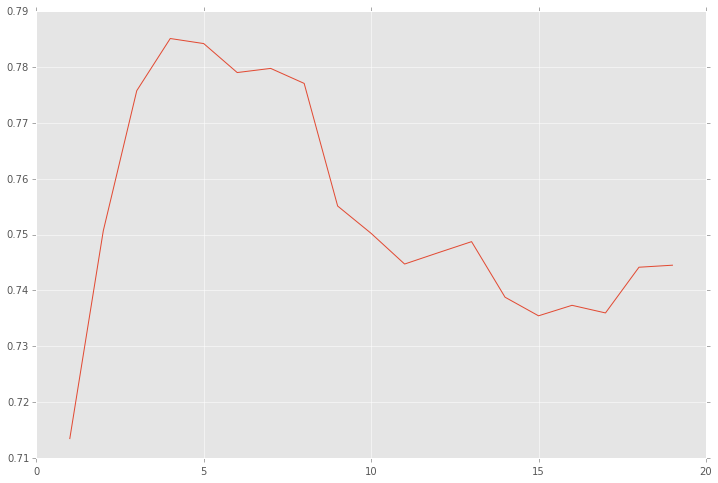

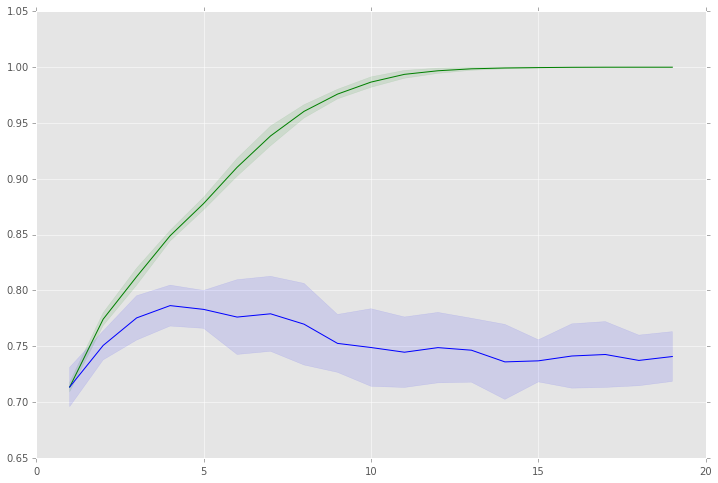

In [65]:
np.random.seed(1337)

depths = range(1,2*int(np.log2(train.shape[0])))
scores = np.empty(len(depths))

for i, d in enumerate(depths):
    dtc = DecisionTreeClassifier(max_depth=d)
    dtc.fit(train,train_tgt)
    scores[i] = cross_val_score(dtc,train,train_tgt,scoring="roc_auc",cv=5).mean()

plt.plot(depths,scores)

d_cv = depths[scores.argsort()[-1]]
print "CV says: best d =", d_cv

train_scores, valid_scores = validation_curve(DecisionTreeClassifier(),train,train_tgt,"max_depth",depths,cv=5,scoring='roc_auc')

plt.figure()
plt.plot(depths,train_scores.mean(axis=1),c="green")
plt.plot(depths,valid_scores.mean(axis=1),c="blue")
plt.fill_between(depths,train_scores.mean(axis=1)-train_scores.std(axis=1),train_scores.mean(axis=1)+train_scores.std(axis=1),color="green",alpha=.1)
plt.fill_between(depths,valid_scores.mean(axis=1)-valid_scores.std(axis=1),valid_scores.mean(axis=1)+valid_scores.std(axis=1),color="blue",alpha=.1)

magic = valid_scores[:2*d_cv+1]
magic = np.abs(magic.mean(axis=1)[2:] - magic.mean(axis=1)[:-2])
d_vc = depths[magic.argsort()[0]]-1 # account for shift on previous line
print "VC says: best d =", d_vc

model = DecisionTreeClassifier(max_depth=int((d_cv+d_vc)/2)).fit(train,train_tgt)

#### Задание (1 балл)

Отсортируйте признаки по важности. Вектор с важностью признаков можно получить с помощью `model.feature_importances_`

In [98]:
print train.columns[model.feature_importances_.argsort()] # from least to most important

Index([u'density', u'residual sugar', u'citric acid', u'free sulfur dioxide',
       u'pH', u'chlorides', u'fixed acidity', u'volatile acidity',
       u'total sulfur dioxide', u'sulphates', u'alcohol'],
      dtype='object')


#### Задание (2 балла)
* Получите предсказания на тестовой выборке
* Постройте ROC кривые для обучающей и тестовой выборок
* Посчитайте остальные меры качества классификации при пороге в `0.5`

68.4375% of test sample predicted successfully


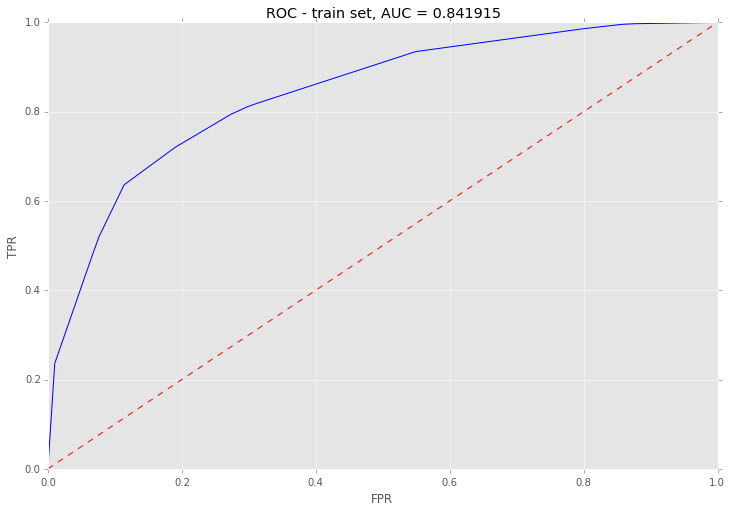

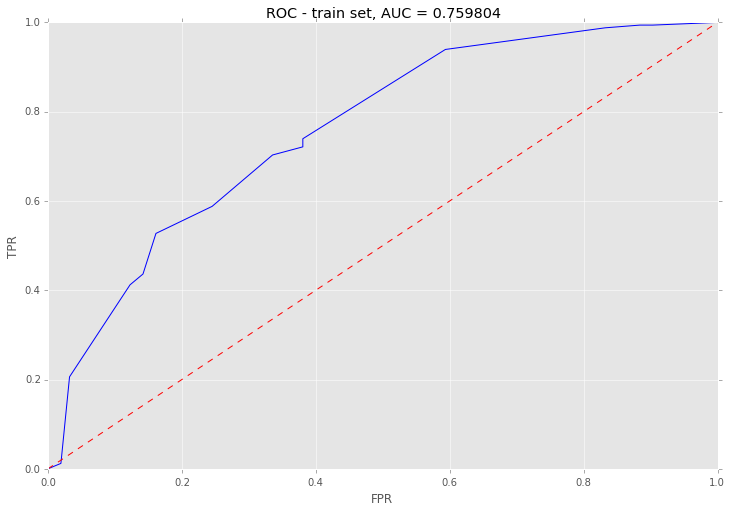

In [69]:
from sklearn.metrics import roc_curve, auc

test_predicted = model.predict(test)
print "%g%% of test sample predicted successfully" % (100.*(test_predicted == test_tgt).sum()/test.shape[0])

train_pred_probs = model.predict_proba(train)[:,1]
fpr, tpr, threshold = roc_curve(train_tgt, train_pred_probs)
roc_auc = auc(fpr, tpr)

plt.title('ROC - train set, AUC = %g' % roc_auc)
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

test_pred_probs = model.predict_proba(test)[:,1]
fpr, tpr, threshold = roc_curve(test_tgt, test_pred_probs)
roc_auc = auc(fpr, tpr)

plt.title('ROC - train set, AUC = %g' % roc_auc)
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

#### Задание (1 балл)
Перейдем к модели случайного леса. Зафиксируем некоторую глубину дерева (можно взять оптимальное с предыдущих заданий).

Сравните качество работы 
* Простого дерева решений
* Бэггинга над 10,20,...,100 деревьями решений
* Случайного леса с 10,20,...,100 деревьями решений

Получите график, у которого по оси X откладывается количество деревьев, а по оси Y - качество классификации.

In [243]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [241]:
# Your Code Here

####  Задание (3 балла)
* С помощью `GridSearchCV` или `RandomSearchCV` подберите наиболее оптимальные параметры для случайного леса.
* Для этих параметров сравните средние результаты по кросс-валидации и качество на контрольной выборке

In [ ]:
# Your Code Here